#Sandbox for cleaning and wrangling tide data for use in a .js based visualization#

**Author:**  Andrew Bauman, PhD

**Purpose:**  Curate a data set for use in Udacity's Data Analyst Nanodegree
Project 6, "Make and Effective Data Visualization."


## Import Modules ##
I have gone overboard on package imports in this notebook with several examples
of unused or redundant imports.  Also, I am relying heavily
on global imports that won't exist in local namespace.  The final
use of this sandbox will be to assemble a scripts for command line
execution.  At that point I will sort out module imports.

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from pandas.io.common import urlopen
import urllib2
from pandas.io import json
from pprint import pprint
import ephem
import datetime
import time
from datetime import datetime
import seaborn; seaborn.set()  # plot styling
%matplotlib inline

##Premise##

I live near Carkeek park.  I can actually walk there (normal pace) in about 15-20 minutes.  Carkeek park is up the Puget Sound from Golden Gardens park, which is also very cool.  I like to hike between the parks, via the sound, and so do others.  The hike is ~2miles.  The tricky thing is knowing whether it is a good time to go "at a glance" or planning a hike in advance.  You need to know whether the tide will be in the correct zone (NGT 2ft) during a time of sufficient light and preferably no rain.  The ideal tide is negative, and the more negative the better.  The ideal weather would be clear and sunny, but not likely to rain would be fine.  So I'm thinking that the minimum conditions to start a hike (from the beach head at either side) should be:

- NLT 1 hour of daylight (1 hour from sunrise or 1 hour after sunset)
- 1 hour of water level NGT 2ft
- LT 50% chance of rain (I now realize this is a tall order for more than 7 days out, so I'm dropping it for initial implementation, users can always look at the tide and daylight vis, then check local weather and decide if it is right for them)

From there, there, good times could be parsed within the minimum paramaters.

This is the tide prediction relative to Mean Lower Low Water Level (MLLW,~ tide relative to mean low water level) for the main Seattle station.  Eventually I can calculate the Carkeek and Golden Gardens data from these values.  Note that the default behaviour for predictions is to return 6 minute prediction data.  I am adding &interval=h to the query to get hourly predictions.  This makes the dataset a little more manageble and also cuts its size by ~10x.

Update, I decided to grab the 6 minute data as well.  I can always resample hourly.

In [2]:
# Example query hourly data
query_hourly = 'http://tidesandcurrents.noaa.gov/api/datagetter?begin_date=20150821%2015:00&end_date=20160820%2015:06&station=9447130&product=predictions&datum=mllw&units=english&time_zone=lst_ldt&interval=h&format=json'

In [3]:
# Example query 6 minute data
query_6min = 'http://tidesandcurrents.noaa.gov/api/datagetter?begin_date=20150821%2015:00&end_date=20160820%2015:06&station=9447130&product=predictions&datum=mllw&units=english&time_zone=lst_ldt&format=json'

Here is the actual object returned by the API call for hourly. Each record contains a string representing a datetime object and a value representing the tide level to MLLW

In [2]:
# EXample hourly JSON object
obj_hourly= '{ "predictions" : [ {"t":"2015-08-21 15:00", "v":"5.374"},{"t":"2015-08-21 16:00", "v":"5.167"},{"t":"2015-08-21 17:00", "v":"5.612"},{"t":"2015-08-21 18:00", "v":"6.570"},{"t":"2015-08-21 19:00", "v":"7.741"},{"t":"2015-08-21 20:00", "v":"8.877"},{"t":"2015-08-21 21:00", "v":"9.777"},{"t":"2015-08-21 22:00", "v":"10.174"},{"t":"2015-08-21 23:00", "v":"9.826"},{"t":"2015-08-22 00:00", "v":"8.723"}]}'

In [1]:
# Example 6 minute JSON object
obj_6min = '{ "predictions" : [ {"t":"2015-08-21 15:00", "v":"5.374"},{"t":"2015-08-21 15:06", "v":"5.326"},{"t":"2015-08-21 15:12", "v":"5.284"},{"t":"2015-08-21 15:18", "v":"5.248"},{"t":"2015-08-21 15:24", "v":"5.217"},{"t":"2015-08-21 15:30", "v":"5.193"},{"t":"2015-08-21 15:36", "v":"5.175"},{"t":"2015-08-21 15:42", "v":"5.163"},{"t":"2015-08-21 15:48", "v":"5.158"}-08-21 16:06", "v":"5.182"}]}'

It looks like I'm going to have to roll up my sleeves and munge this data.  Stand back...

In [6]:
 base_url = 'http://tidesandcurrents.noaa.gov/api/datagetter?'

In [7]:
# dict of noaa query paramaters/arguments
query_args = {    
'begin_date':'20150821 00:00',
'end_date':'20160820 23:00',
'station':'9447130',
'product':'predictions',
'datum':'mllw',
'units':'english',
'time_zone':'lst_ldt',
'format':'json'
}

In [8]:
def query_builder(query_dict,base_url):
    '''Function accepts a base url 
    and a query parameters/arguments dict
    and returns an API query.
    Note that NOAA COOPS API default is 6 minutes
    and no interval need be specified in the dict'''

    import urllib
    
    base_url = base_url

    # encode arguments

    encoded_args = urllib.urlencode(query_dict)

    # create query from base url and encoded arguments

    return base_url + encoded_args

In [9]:
def dt_periodizer(query_dict):
    '''Function accepts a dictionary of query parameters
    containing end and start dt objects and an interval and calculates
    the number of periods that should be returned if all
    periods of the requested interval are populated with
    data. Note that NOAA COOPS API default is 6 minutes
    and no interval need be specified in the dict'''
    
    begin = datetime.strptime(query_dict['begin_date'].replace(" ",""), '%Y%m%d%H:%M')
    end = datetime.strptime(query_dict['end_date'].replace(" ",""), '%Y%m%d%H:%M')

    d = end - begin

    hours = (d.seconds/60/60) + (d.days * 24)

    periods = hours * 10 # 10 6 minute periods per hour
    
    return periods, begin, end

In [10]:
noaa_query = query_builder(query_args,base_url)
noaa_query

'http://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&station=9447130&begin_date=20150821+00%3A00&end_date=20160820+23%3A00&format=json&units=english&datum=mllw&time_zone=lst_ldt'

In [12]:
periods, begin, end = dt_periodizer(query_args)
periods

87830

In [13]:
begin.strftime('%Y-%m-%d %H:%M:%S')

'2015-08-21 00:00:00'

In [14]:
def get_COOPS_json(query_dict, base_url):
    '''Function accepts a NOAA tides and currents prediction query
    with form= json (query returns json object).
    Function returns the hourly prediction data as a PANDAS DataFrame Object
    where the returned time becomes the datetime index.'''
    
    
    # import dependencies
    import pandas as pd
    import numpy as np
    from pandas.io.common import urlopen
    from pandas.io import json  
    
    # construct the query
    
    query = query_builder(query_dict,base_url)    
    
    
    # execute query and read response
        
    with urlopen(query) as response:
        data = response.read()

        
        # convert json object to python dictionary
        # and extract time and values for predictions

        data = json.loads(data)['predictions']

        # read into PANDAS DataFrame, then manipulate
        # DataFrame object
        data = pd.DataFrame(data)
        data.columns = ['Date_Time','Level']
        data.index = data.Date_Time 
        data.index = pd.to_datetime(data.index)
        data =data.drop('Date_Time',axis=1)

        # reindex to fill in any missing time values, this needs
        # work to initialize the range on the data/query vs. hardcoding as it 
        # currently stands.
        
        periods, begin, end = dt_periodizer(query_dict)
        
        begin_string = begin.strftime('%Y-%m-%d %H:%M:%S')

        rng = pd.date_range(begin_string, periods = periods, freq='6min')

        # the actual reindex itself needs to be reworked for a better fill
        # a good start might be the median of the points directly above and
        # below the missing dt index. Since this is very few points typically
        # I am filling them with 100 for easy removal later. I would rather
        # remove the points than fill in a nonmeasured value.

        data  = data.reindex(rng, fill_value= 100)


        # convert value from string to float
        data.Level = data.Level.astype(float)

        # adjust level to account for distance of Carkeek from NOAA
        # monitoring station (+ 5.5%)
        data.Level = np.round(data.Level + (.05 * data.Level),decimals=2)

        # add date column to dataframe for later use with weather data
        data['Date'] = data.index.date

        # add a column for hourly re-sample

        #data['Hour'] = data.index.hour
        #data['Time'] = data.index.time




        # return DataFrame object
        return data

In [15]:
df_sixmin = get_COOPS_json(query_args,base_url)

In [16]:
df_sixmin.head()

,Level,Date
2015-08-21 00:00:00,8.26,2015-08-21
2015-08-21 00:06:00,8.07,2015-08-21
2015-08-21 00:12:00,7.87,2015-08-21
2015-08-21 00:18:00,7.68,2015-08-21
2015-08-21 00:24:00,7.48,2015-08-21


In [17]:
df_sixmin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87830 entries, 2015-08-21 00:00:00 to 2016-08-20 22:54:00
Freq: 6T
Data columns (total 2 columns):
Level    87830 non-null float64
Date     87830 non-null object
dtypes: float64(1), object(1)
memory usage: 2.0+ MB


making some notes on how services calculate carkeek park tides.  pipers creek entrance is ~ .6m away.

The Data
Tide times data has been adjusted for daylight saving where and when applicable. WillyWeather interpolates its tide times for many locations by converting the tide forecasts provided by the National Oceanic and Atmospheric Administration. The tide times on the Pipers Creek Entrance tides page have been adjusted by -2 mins for low tide and 1 mins for high tide to the official tide times for Seattle. Tide height data is offset from Seattle by %5% feet for high tide and %6% feet for low tide.

meadowpoint may actually be the closest place noaa takes data to carkeek

The Data
Tide times data has been adjusted for daylight saving where and when applicable. WillyWeather interpolates its tide times for many locations by converting the tide forecasts provided by the National Oceanic and Atmospheric Administration. The tide times on the Meadow Point tides page have been adjusted by -1 mins for low tide and 0 mins for high tide to the official tide times for Seattle. Tide height data is offset from Seattle by %5% feet for high tide and %6% feet for low tide.

I'm not really concerned about 1 or 2 minute, but 5-6% on tide heights may make a slight difference so I'll incorporate that.  I'm going to adjust every tide level by + 5.5%

## Sunrise and Sunset

Starter code for sunrise and sunset calculations.  Note that this takes a long time to execute using every row in the index.  A better approach would be to make the calculation just for the days.  That way you would make the calculation no more than 365 times.  

In [18]:
# write function to populate df with sunrise and sunset
# note that date will need formatting and conversion to local time

def get_sunrise_sunset(date, lon= -122.3783, lat= 47.7128):
    
    '''Function accepts a date string, and location float coordinates
    Function returns local, sunrise and sunset time
    datetime objects'''
    
    #import ephem
    #from datetime import datetime

    # Make an observer
    o = ephem.Observer()

    # PyEphem takes and returns only UTC times. 19:00 is Noon PDT, 20:00 is Noon PST
    # Using a string conversion and operation, which is probably slow
    # and could use optimization
    o.date = str(date) + ' 19:00'
    

    # Location of Carkeek Park
    o.lon  = str(lon) #Note that lon should be in string format
    o.lat  = str(lat) #Note that lat should be in string format

    # Elevation of the beach extending from Carkeek Park
    o.elev = 0


    sunrise=o.previous_rising(ephem.Sun()) #Sunrise
    sunset =o.next_setting(ephem.Sun()) #Sunset
    
    # convert sunrise and sunset to localtime (PDT/PST)
    local_sunrise = ephem.localtime(ephem.date(sunrise))
    local_sunset = ephem.localtime(ephem.date(sunset))
    
    return {'sunrise':local_sunrise,'sunset':local_sunset}

In [19]:
def strip_timestamp(timestamp):
    '''Function accepts a timestamp and strips date and microseconds
    returning hours, minutes, seconds'''
    
    timestamp = timestamp.time()
    timestamp = timestamp.replace(microsecond = 0)
    
    return timestamp

The following is a set of anonymous functions (lambda) for the purposes of making 
vectorized calcualtions using the dt index.  I created these as I explored the data
and encountered challenges.  Many of these functions could be used more efficiently,
some can be eliminated, some combined.  At the very least I calculate and recalculate
comparator and bounds colmuns, which should only be done once.  This will be sorted
for the .py script.

In [20]:
# lambda function to calculate sunrise and sunset times and populate df columns

df_sixmin['Sunrise_dt'] = df_sixmin.Date.apply(lambda x:get_sunrise_sunset(x)['sunrise'])
df_sixmin['Sunset_dt'] = df_sixmin.Date.apply(lambda x:get_sunrise_sunset(x)['sunset'])

In [21]:
# lambda functions to calculate time until sunrise and sunset for each dt object

df_sixmin['Delta_Sunrise'] = (df_sixmin.index - df_sixmin.Sunrise_dt)
df_sixmin['Delta_Sunset'] = (df_sixmin.index - df_sixmin.Sunset_dt)

# lambda functiions to convert Timedelta to integer number of hours

df_sixmin.Delta_Sunset = df_sixmin.Delta_Sunset.apply(lambda x: x/np.timedelta64(1, 's')/3600)
df_sixmin.Delta_Sunrise = df_sixmin.Delta_Sunrise.apply(lambda x: x/np.timedelta64(1, 's')/3600)

Okay now we have established how to index by a timedelta, let's create the actual comparisons.

- enough light:  Is there at least 1 hour of sunlight as defined by sunrise and sunset times
- enough beach:  Is there at least 1 hour of beach left (tide 2 feet or below)
- start the hike or not?


In [22]:
def enough_light(df):
    '''Function accepts a dataframe and 
    returns a string, yes or no, where yes
    indicates there is at least 1 hour of daylight left'''
    
    if df['Delta_Sunrise'] >= -.5 and df['Delta_Sunset'] <= -1:
        return 'yes'
    else:
        return 'no'

In [23]:
# lambda function to determine if there is at least 1 hour of light left for a dt object

df_sixmin['enough_light'] = df_sixmin.apply(lambda x: enough_light(x),axis =1)

In [24]:
# create dt object shifted 1 hour forward from dt index

shift_ts = df_sixmin.index + pd.Timedelta('1h')

# shift_ts.isin(df_sixmin.index) is boolean to determine iif shifted value exists in the dt index
# several rows on the tail will have a shift_ts that is not in the index

# lambda function to determine if shifted_ts is in bounds or not

df_sixmin['inbounds_ts'] = df_sixmin.apply(lambda x: shift_ts.isin(x.index)).Level

In [25]:
# accessing the index for axis = 1 lambda functions can be a challenge
# this is being handled by creating a column that matches the dt object
# index values.

df_sixmin['temp_index'] = df_sixmin.index

In [26]:
def shift_ts(row):
    '''Functions accepts a boolean row from a PANDAS DF,
    evaluates whether it is T or F and returns either
    the dt object or the 1 hour shifted dt object
    from a column represeting the dt index'''
    
    if row.inbounds_ts == True:
        return row.temp_index + pd.Timedelta('1h')
    else:
        return row.temp_index

In [27]:
# lambda function to create a column with index dt + Timdedelta('1h')

df_sixmin['shift_ts'] = df_sixmin.apply(lambda x: shift_ts(x),axis=1)

In [28]:
# lambda function to create a column with the tide level 1 hour from the dt index

df_sixmin['shift_level'] = df_sixmin[['Level','shift_ts']].apply(lambda x: df_sixmin.loc[x[1]],axis =1).Level

In [29]:
# select columns of interest

cols = ['Level', 'Delta_Sunset','Delta_Sunrise','enough_light','shift_level']
df_sixmin = df_sixmin[cols]

In [42]:
def enough_beach(row):
    '''Function accepts a dataframe and 
    returns a string, yes or no, where yes
    indicates there is at least 1 hour where
    the tide is <= 2 feet'''
    
    if row.shift_level <= 2 and row.Level <=2:
        return 'yes'
    else:
        return 'no'

In [43]:
# lambda functon to determine if there is enough beach (tide <=2ft)
# at time 1 hour out from current row/dt index

df_sixmin['enough_beach'] = df_sixmin.apply(lambda x: enough_beach(x), axis=1)

In [44]:
def go_stay(row):
    
    ''' Function accepts PANDAS DF row, 
    evaluates the value of enough_light and enough_beach
    then returns a value of either wait or walk (stay
    at the park or travel to Golden Gardens)'''
    
    if row.enough_light == 'yes' and row.enough_beach == 'yes':
        return 'walk'
    else:
        return 'wait'

In [45]:
# lambda function which populates DF column with the result
# of stay (stay at park) or go (enough light and beach to make hike)

df_sixmin['go_stay'] = df_sixmin.apply(lambda x: go_stay(x), axis =1)

### Debugging 1 ###

In [37]:
df_sixmin['Date'] = df_sixmin.index.date

date_selector = df_sixmin.Date == pd.datetime(2015,8,23,0,0).date()
date_selector2 = df_sixmin.Date == pd.datetime(2015,8,22,0,0).date()
date_selector_sep = df_sixmin.Date == pd.datetime(2015,9,26,0,0).date()



I noticed the data visualization in dimple didn't look quite right for 22 August 2015. Note that there aren't any walk times, but it passed the filter.  See df_enough selection below.  This is because I am selecting on enough light and enough beach but not if they occur simaltaneously.  I will fix this by selecting for both he presence of start and stop.

In [46]:
set(df_sixmin[['Level','shift_level','enough_light','enough_beach','Date','go_stay']][date_selector2].go_stay == "walk")

{False}

Visualising the data I also noticed that there were several days where the hike window started at a level above 2 feet, but fell to 2 feet or below withing 1 hour.  September 26 was one such day.  The issue is with the enough_beach calculation.  The original enough_beach calculation was as follows:

def enough_beach(row):
    '''Function accepts a dataframe and 
    returns a string, yes or no, where yes
    indicates there is at least 1 hour where
    the tide is <= 2 feet'''
    
    if row.shift_level <= 2:
        return 'yes'
    else:
        return 'no'
        
As you can see, this only checks 1 hour forward.  This works well for the end of the hike window, but not the begginning.  To start a hike two things would have to be true.  Both the current level and the level 1 hour forward would have to meet the condition of NGT 2 feet. 

Changing to the the following seems to have fixed the issue:

def enough_beach(row):
    '''Function accepts a dataframe and 
    returns a string, yes or no, where yes
    indicates there is at least 1 hour where
    the tide is <= 2 feet'''
    
    if row.shift_level <= 2 and row.Level <=2:
        return 'yes'
    else:
        return 'no'


### End Debugging 1 ###

In [50]:
# create dt object shifted 6 minutes forward from dt index

shift_6min_ts = df_sixmin.index + pd.Timedelta('6m')

# shift_6min_ts.isin(df_sixmin.index) is boolean to determine if shifted value exists in the dt index
# several rows on the tail will have a shift_6min_ts that is not in the index

# lambda function to determine if shifted_6min_ts is in bounds or not

df_sixmin['inbounds_6min_ts'] = df_sixmin.apply(lambda x: shift_6min_ts.isin(x.index)).Level

In [51]:
# accessing the index for axis = 1 lambda functions can be a challenge
# this is being handled by creating a column that matches the dt object
# index values.

df_sixmin['temp_index'] = df_sixmin.index

In [52]:
def shift_ts_6min(row,shift_string):
    '''Functions accepts a boolean row from a PANDAS DF,
    and a time shift string (i.e. '1h', '1m')
    evaluates whether it is T or F and returns either
    the dt object or the time shifted dt object
    from a column represeting the dt index'''
    
    if row.inbounds_6min_ts == True:
        return row.temp_index + pd.Timedelta(shift_string)
    else:
        return row.temp_index

In [53]:
# lambda function to create a column with index dt + Timdedelta('6m')

df_sixmin['shift_6min_ts'] = df_sixmin.apply(lambda x: shift_ts_6min(x,'6m'),axis=1)

In [54]:
# lambda function to create a column with the go_stay status 6 minutes from the dt index

df_sixmin['next_status'] = df_sixmin[['go_stay','shift_6min_ts']].apply(lambda x: df_sixmin.loc[x[1]],axis =1).go_stay

In [55]:
def start_stop(row):
    
    '''Function excepts a PANDAS DF row and determines
    the current condition (wait/stay or go), compares it
    to the condition at the next timedelta, and 
    returns wait/stay, earliest start, walk/go, or latest start'''
    current_condition = row.go_stay
    next_condition = row.next_status
    
    if current_condition == next_condition:
        return current_condition
    elif current_condition != next_condition:
        if next_condition == 'walk':
            return 'earliest_start'
        else:
            return 'latest_start'

In [56]:
# lambda function to populate the a start_stop DF column with the results
# of the start_stop function (returns wait/stay, stop, go, or start)

df_sixmin['start_stop'] = df_sixmin.apply(lambda x: start_stop(x), axis=1)

In [57]:
df_sixmin[['go_stay','next_status','start_stop']]

,go_stay,next_status,start_stop
2015-08-21 00:00:00,wait,wait,wait
2015-08-21 00:06:00,wait,wait,wait
2015-08-21 00:12:00,wait,wait,wait
2015-08-21 00:18:00,wait,wait,wait
2015-08-21 00:24:00,wait,wait,wait
2015-08-21 00:30:00,wait,wait,wait
2015-08-21 00:36:00,wait,wait,wait
2015-08-21 00:42:00,wait,wait,wait
2015-08-21 00:48:00,wait,wait,wait
2015-08-21 00:54:00,wait,wait,wait


### Add walk completion ###

The earliest start and latest start are just that, the earliest and latest reccomended time for starting the hike where 1 hour of light and beach are most likely.  Following the latest start there should be 1 hour of walk time left.  I've decided to add this explicitly into the df.

In [58]:
# create dt object shifted 1 hour back from dt index

shift_neghour_ts = df_sixmin.index + pd.Timedelta('-1h')

# shift_neghour_ts.isin(df_sixmin.index) is boolean to determine if shifted value exists in the dt index
# several rows on the head will have a shift_6min_ts that is not in the index

# lambda function to determine if shifted_neghour_ts is in bounds or not

df_sixmin['inbounds_neghour_ts'] = df_sixmin.apply(lambda x: shift_neghour_ts.isin(x.index)).Level

In [59]:
# accessing the index for axis = 1 lambda functions can be a challenge
# this is being handled by creating a column that matches the dt object
# index values.

df_sixmin['temp_index'] = df_sixmin.index

In [60]:
def shift_ts_neghour(row,shift_string):
    '''Functions accepts a boolean row from a PANDAS DF,
    and a time shift string (i.e. '1h', '1m')
    evaluates whether it is T or F and returns either
    the dt object or the time shifted dt object
    from a column represeting the dt index'''
    
    if row.inbounds_neghour_ts == True:
        return row.temp_index + pd.Timedelta(shift_string)
    else:
        return row.temp_index

In [61]:
# lambda function to create a column with index dt + Timdedelta('-1h')

df_sixmin['shift_neghour_ts'] = df_sixmin.apply(lambda x: shift_ts_neghour(x,'-1h'),axis=1)

In [62]:
# lambda function to create a column with the start_stop value 1 hour previous from the dt index

df_sixmin['prev_status'] = df_sixmin[['start_stop','shift_neghour_ts']].apply(lambda x: df_sixmin.loc[x[1]],axis =1).start_stop

In [63]:
# function to add value of complete hike

def complete_hike(row):
    
    '''Function excepts a PANDAS DF row and determines
    the current condition of start_stop, compares it
    to the condition 1 hour previous, and 
    returns either the current start_stop condition of 
    complete_hike'''
    current_condition = row.start_stop
    prev_condition = row.prev_status
    
    if prev_condition == "latest_start":
        return "complete_hike"
    else:
        return current_condition

In [64]:
# lambda function to populate the a start_stop DF column with the results
# of the start_stop function (returns wait/stay, stop, go, or start)

df_sixmin['start_stop'] = df_sixmin.apply(lambda x: complete_hike(x), axis=1)

### Debugging 2 ###

In [66]:
df_sixmin['Date'] = df_sixmin.index.date

date_selector3 = df_sixmin.Date == pd.datetime(2015,8,23,0,0).date()
date_selector4 = df_sixmin.Date == pd.datetime(2015,8,24,0,0).date()



In [67]:
df_sixmin[['Level','Date','go_stay','next_status','start_stop']][date_selector3][50:80]

,Level,Date,go_stay,next_status,start_stop
2015-08-23 05:00:00,1.85,2015-08-23,wait,wait,wait
2015-08-23 05:06:00,1.77,2015-08-23,wait,wait,wait
2015-08-23 05:12:00,1.70,2015-08-23,wait,wait,wait
2015-08-23 05:18:00,1.65,2015-08-23,wait,wait,wait
2015-08-23 05:24:00,1.60,2015-08-23,wait,wait,wait
2015-08-23 05:30:00,1.56,2015-08-23,wait,wait,wait
2015-08-23 05:36:00,1.54,2015-08-23,wait,wait,wait
2015-08-23 05:42:00,1.52,2015-08-23,wait,walk,earliest_start
2015-08-23 05:48:00,1.51,2015-08-23,walk,wait,latest_start
2015-08-23 05:54:00,1.52,2015-08-23,wait,wait,wait


In [68]:
df_sixmin[['Level','Date','go_stay','next_status','start_stop']][date_selector3][50:80]

,Level,Date,go_stay,next_status,start_stop
2015-08-23 05:00:00,1.85,2015-08-23,wait,wait,wait
2015-08-23 05:06:00,1.77,2015-08-23,wait,wait,wait
2015-08-23 05:12:00,1.70,2015-08-23,wait,wait,wait
2015-08-23 05:18:00,1.65,2015-08-23,wait,wait,wait
2015-08-23 05:24:00,1.60,2015-08-23,wait,wait,wait
2015-08-23 05:30:00,1.56,2015-08-23,wait,wait,wait
2015-08-23 05:36:00,1.54,2015-08-23,wait,wait,wait
2015-08-23 05:42:00,1.52,2015-08-23,wait,walk,earliest_start
2015-08-23 05:48:00,1.51,2015-08-23,walk,wait,latest_start
2015-08-23 05:54:00,1.52,2015-08-23,wait,wait,wait


In [70]:
df_sixmin[['Level','Date','go_stay','next_status','start_stop']][date_selector4][50:85]

,Level,Date,go_stay,next_status,start_stop
2015-08-24 05:00:00,2.63,2015-08-24,wait,wait,wait
2015-08-24 05:06:00,2.47,2015-08-24,wait,wait,wait
2015-08-24 05:12:00,2.31,2015-08-24,wait,wait,wait
2015-08-24 05:18:00,2.16,2015-08-24,wait,wait,wait
2015-08-24 05:24:00,2.02,2015-08-24,wait,wait,wait
2015-08-24 05:30:00,1.89,2015-08-24,wait,wait,wait
2015-08-24 05:36:00,1.76,2015-08-24,wait,wait,wait
2015-08-24 05:42:00,1.64,2015-08-24,wait,walk,earliest_start
2015-08-24 05:48:00,1.54,2015-08-24,walk,walk,walk
2015-08-24 05:54:00,1.44,2015-08-24,walk,walk,walk


### End Debugging 2 ###

In [72]:
# select columns of interest

cols = ['Level', 'Delta_Sunset','Delta_Sunrise','shift_level','start_stop','enough_light',
        'enough_beach', 'Sunrise_dt', 'Sunset_dt']
df_sixmin = df_sixmin[cols]

In [73]:
df_sixmin.head()

,Level,Delta_Sunset,Delta_Sunrise,shift_level,start_stop,enough_light,enough_beach
2015-08-21 00:00:00,8.26,-20.195278,-6.210278,6.25,wait,no,no
2015-08-21 00:06:00,8.07,-20.095278,-6.110278,6.05,wait,no,no
2015-08-21 00:12:00,7.87,-19.995278,-6.010278,5.84,wait,no,no
2015-08-21 00:18:00,7.68,-19.895278,-5.910278,5.64,wait,no,no
2015-08-21 00:24:00,7.48,-19.795278,-5.810278,5.43,wait,no,no


### Data check ##

- spot check of sunrise and sunset times for PST and PDT revealed that calculated times match published
- A plot of weekly tide levels for a sample week (week 35), shown below was a good match for NOAA tide curves
- A spot check of tide levels matches pattern and magnitude of highs and lows + 5.5% compared to NOAA data

http://tidesandcurrents.noaa.gov/noaatidepredictions/NOAATidesFacade.jsp?Stationid=9447130&bmon=08&bday=26&byear=2015&edate=&timelength=weekly&timeZone=2&dataUnits=1&datum=MLLW&timeUnits=2&interval=highlow&Threshold=greaterthanequal&format=Submit

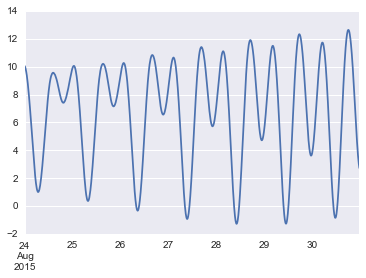

In [74]:
df_sixmin[df_sixmin.index.week ==35].Level.plot()

In [76]:
df_sixmin[df_sixmin.index.week == 35][930:980]

,Level,Delta_Sunset,Delta_Sunrise,shift_level,start_stop,enough_light,enough_beach
2015-08-27 21:00:00,6.45,0.993333,14.6550,5.75,wait,no,no
2015-08-27 21:06:00,6.34,1.093333,14.7550,5.73,wait,no,no
2015-08-27 21:12:00,6.24,1.193333,14.8550,5.72,wait,no,no
2015-08-27 21:18:00,6.15,1.293333,14.9550,5.72,wait,no,no
2015-08-27 21:24:00,6.06,1.393333,15.0550,5.73,wait,no,no
2015-08-27 21:30:00,5.99,1.493333,15.1550,5.75,wait,no,no
2015-08-27 21:36:00,5.92,1.593333,15.2550,5.78,wait,no,no
2015-08-27 21:42:00,5.87,1.693333,15.3550,5.81,wait,no,no
2015-08-27 21:48:00,5.82,1.793333,15.4550,5.86,wait,no,no
2015-08-27 21:54:00,5.78,1.893333,15.5550,5.91,wait,no,no


### General Strategy ###

- Previous EDA (not shown) revealed ~ 155 days per year as meeting criteria to hike (enough light and beach)
- This was distrubuted over 9 total months and 35 total weeks
- Decided on a strategy where either an entire week is shows, or an entire day is shown
- Further EDA and visualiation shoudl reveal which is best

### EDA ###

In [99]:
df_sixmin['Month'] = df_sixmin.index.month
df_sixmin['Week'] = df_sixmin.index.week
df_sixmin['Date'] = df_sixmin.index.date
df_sixmin['Day'] = df_sixmin.index.dayofyear
df_sixmin['Time'] = df_sixmin.index.time
df_sixmin['DateTime'] = df_sixmin.index

C:\Users\Andrew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Andrew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\Andrew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

The selection below is problematic, it selects any day with enough light and enough beach, not necessarily those that have it at the same time.  You should use start and stop as selectors, a day should have both a start and a stop time.  I'm actually going to try this with just a start time.

df_enough = df_sixmin[(df_sixmin.enough_beach == 'yes') & (df_sixmin.enough_light == 'yes')]

In [78]:
df_enough = df_sixmin[(df_sixmin.start_stop == 'earliest_start')]
df_enough.head()

,Level,Delta_Sunset,Delta_Sunrise,shift_level,start_stop,enough_light,enough_beach,Month,Week,Date,Day,Time,DateTime
2015-08-23 05:42:00,1.52,-14.433333,-0.555278,1.89,earliest_start,no,yes,8,34,2015-08-23,235,05:42:00,2015-08-23 05:42:00
2015-08-24 05:42:00,1.64,-14.401944,-0.577778,1.01,earliest_start,no,yes,8,35,2015-08-24,236,05:42:00,2015-08-24 05:42:00
2015-08-25 06:00:00,2.09,-14.070278,-0.300000,0.72,earliest_start,yes,no,8,35,2015-08-25,237,06:00:00,2015-08-25 06:00:00
2015-08-26 06:42:00,2.05,-13.338611,0.377500,0.31,earliest_start,yes,no,8,35,2015-08-26,238,06:42:00,2015-08-26 06:42:00
2015-08-27 07:24:00,2.09,-12.606667,1.055000,0.00,earliest_start,yes,no,8,35,2015-08-27,239,07:24:00,2015-08-27 07:24:00


In [79]:
# number of good days

len(df_enough.groupby(df_enough.index.date).mean())

155

In [80]:
# number of weeks with good days

len(df_enough.groupby(df_enough.index.week).mean())

35

In [81]:
# number of months with good days

len(df_enough.groupby(df_enough.index.month).count())

9

In [82]:
# which weeks?

df_enough.groupby(df_enough.index.week).mean().index

Int64Index([ 6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41,
            43],
           dtype='int64')

In [83]:
# which months?

df_enough.groupby(df_enough.index.month).mean().index

Int64Index([2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

In [84]:
# get good weeks (the entire week)

df_enough_weeks= df_sixmin[(df_sixmin.Week.isin(df_sixmin.Week.unique())) & (df_sixmin.Level < 100)]

df_enough_weeks.head()

,Level,Delta_Sunset,Delta_Sunrise,shift_level,start_stop,enough_light,enough_beach,Month,Week,Date,Day,Time,DateTime
2015-08-21 00:00:00,8.26,-20.195278,-6.210278,6.25,wait,no,no,8,34,2015-08-21,233,00:00:00,2015-08-21 00:00:00
2015-08-21 00:06:00,8.07,-20.095278,-6.110278,6.05,wait,no,no,8,34,2015-08-21,233,00:06:00,2015-08-21 00:06:00
2015-08-21 00:12:00,7.87,-19.995278,-6.010278,5.84,wait,no,no,8,34,2015-08-21,233,00:12:00,2015-08-21 00:12:00
2015-08-21 00:18:00,7.68,-19.895278,-5.910278,5.64,wait,no,no,8,34,2015-08-21,233,00:18:00,2015-08-21 00:18:00
2015-08-21 00:24:00,7.48,-19.795278,-5.810278,5.43,wait,no,no,8,34,2015-08-21,233,00:24:00,2015-08-21 00:24:00


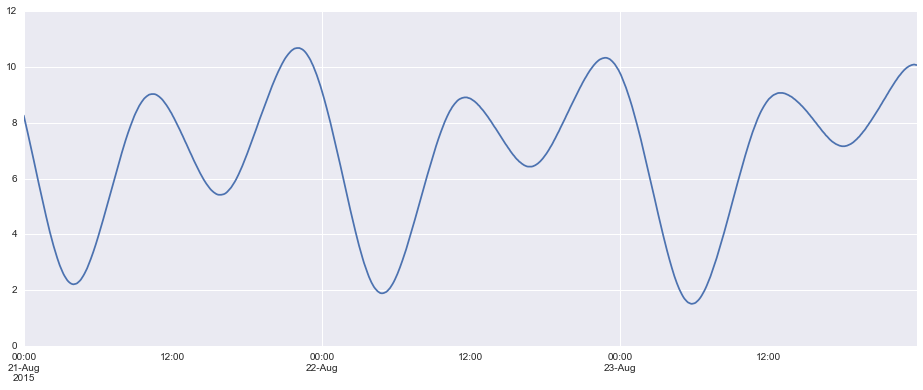

In [85]:
# we only have part of week 34 so this is a plot of 2 consecutive days

df_enough_weeks[df_enough_weeks.Week == 34].Level.plot(figsize = (16,6))

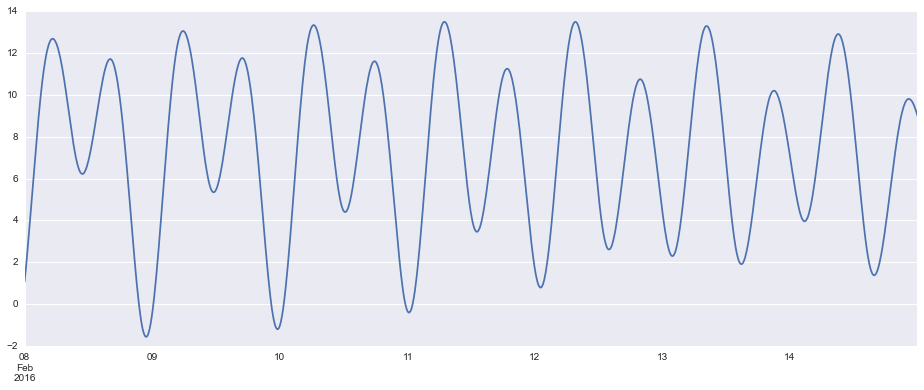

In [86]:
df_enough_weeks[df_enough_weeks.Week == 6].Level.plot(figsize = (16,6))

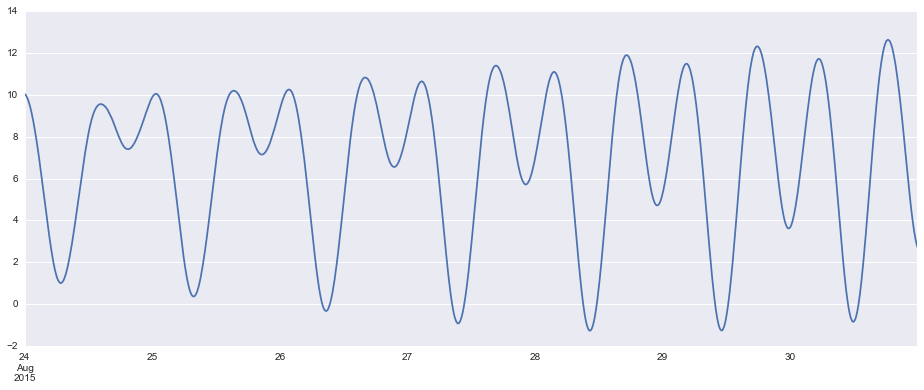

In [87]:
df_enough_weeks[df_enough_weeks.Week == 35].Level.plot(figsize = (16,6))

###Select Viable Days###
Select the entire day for each viable day.

In [88]:
# get good days (the entire day)

df_enough_days= df_sixmin[(df_sixmin.Date.isin(df_enough.Date.unique())) & (df_sixmin.Level < 100)]

df_enough_days.head()

,Level,Delta_Sunset,Delta_Sunrise,shift_level,start_stop,enough_light,enough_beach,Month,Week,Date,Day,Time,DateTime
2015-08-23 00:00:00,9.80,-20.133333,-6.255278,8.57,wait,no,no,8,34,2015-08-23,235,00:00:00,2015-08-23 00:00:00
2015-08-23 00:06:00,9.71,-20.033333,-6.155278,8.41,wait,no,no,8,34,2015-08-23,235,00:06:00,2015-08-23 00:06:00
2015-08-23 00:12:00,9.60,-19.933333,-6.055278,8.25,wait,no,no,8,34,2015-08-23,235,00:12:00,2015-08-23 00:12:00
2015-08-23 00:18:00,9.50,-19.833333,-5.955278,8.09,wait,no,no,8,34,2015-08-23,235,00:18:00,2015-08-23 00:18:00
2015-08-23 00:24:00,9.38,-19.733333,-5.855278,7.92,wait,no,no,8,34,2015-08-23,235,00:24:00,2015-08-23 00:24:00


In [109]:
df_enough_days.columns

Index([u'Level', u'Delta_Sunset', u'Delta_Sunrise', u'shift_level',
       u'start_stop', u'enough_light', u'enough_beach', u'Month', u'Week',
       u'Date', u'Day', u'Time', u'DateTime'],
      dtype='object')

In [114]:
# check September 26

df_enough_days[['Level','shift_level','enough_light','enough_beach','start_stop','Date']][date_selector_sep][80:120]



,Level,shift_level,enough_light,enough_beach,start_stop,Date
2015-09-26 08:00:00,2.85,0.95,yes,no,wait,2015-09-26
2015-09-26 08:06:00,2.62,0.83,yes,no,wait,2015-09-26
2015-09-26 08:12:00,2.40,0.71,yes,no,wait,2015-09-26
2015-09-26 08:18:00,2.18,0.62,yes,no,earliest_start,2015-09-26
2015-09-26 08:24:00,1.97,0.53,yes,yes,walk,2015-09-26
2015-09-26 08:30:00,1.78,0.46,yes,yes,walk,2015-09-26
2015-09-26 08:36:00,1.59,0.41,yes,yes,walk,2015-09-26
2015-09-26 08:42:00,1.41,0.37,yes,yes,walk,2015-09-26
2015-09-26 08:48:00,1.25,0.34,yes,yes,walk,2015-09-26
2015-09-26 08:54:00,1.09,0.33,yes,yes,walk,2015-09-26


In [115]:
# check earliest starts

df_enough[['Level','shift_level','enough_light','enough_beach','start_stop','Date']]


,Level,shift_level,enough_light,enough_beach,start_stop,Date
2015-08-23 05:42:00,1.52,1.89,no,yes,earliest_start,2015-08-23
2015-08-24 05:42:00,1.64,1.01,no,yes,earliest_start,2015-08-24
2015-08-25 06:00:00,2.09,0.72,yes,no,earliest_start,2015-08-25
2015-08-26 06:42:00,2.05,0.31,yes,no,earliest_start,2015-08-26
2015-08-27 07:24:00,2.09,0.00,yes,no,earliest_start,2015-08-27
2015-08-28 08:06:00,2.28,-0.09,yes,no,earliest_start,2015-08-28
2015-08-29 09:00:00,2.09,-0.27,yes,no,earliest_start,2015-08-29
2015-08-30 09:54:00,2.15,-0.08,yes,no,earliest_start,2015-08-30
2015-08-31 11:00:00,2.03,0.28,yes,no,earliest_start,2015-08-31
2015-09-01 12:18:00,2.03,1.12,yes,no,earliest_start,2015-09-01


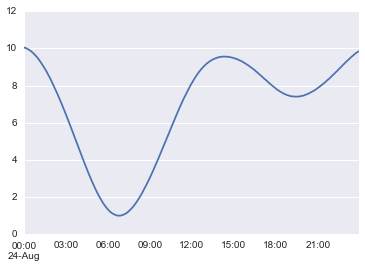

In [90]:
# plotting a single day of the year

df_enough_days[df_enough_days.Day == 236].Level.plot()

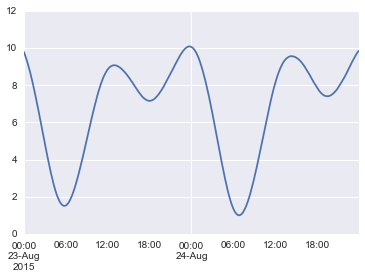

In [91]:
# plotting 2 consecutive days

df_enough_days[df_enough_days.Day.isin([235,236])].Level.plot()

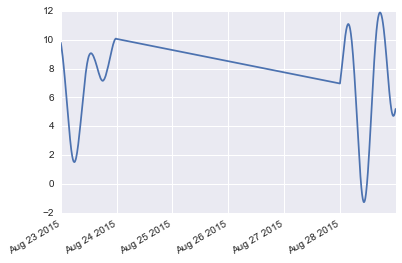

In [92]:
# plotting 2 non-consecutive days

df_enough_days[df_enough_days.Day.isin([235,240])].Level.plot()

# so yeah, should clearly use subplots 

### Start moving this into a useful form for dimple ###



In [93]:
dimple_cols = ['Level', 'start_stop','Date','Time','DateTime','Day', 'Sunrise_dt','Sunset_dt']
df_dimple_days = df_enough_days[dimple_cols]
df_dimple_weeks = df_enough_weeks[dimple_cols]

In [94]:
df_dimple_days.head()

,Level,start_stop,Date,Time,DateTime,Day
2015-08-23 00:00:00,9.80,wait,2015-08-23,00:00:00,2015-08-23 00:00:00,235
2015-08-23 00:06:00,9.71,wait,2015-08-23,00:06:00,2015-08-23 00:06:00,235
2015-08-23 00:12:00,9.60,wait,2015-08-23,00:12:00,2015-08-23 00:12:00,235
2015-08-23 00:18:00,9.50,wait,2015-08-23,00:18:00,2015-08-23 00:18:00,235
2015-08-23 00:24:00,9.38,wait,2015-08-23,00:24:00,2015-08-23 00:24:00,235


In [95]:
df_dimple_weeks.head()

,Level,start_stop,Date,Time,DateTime,Day
2015-08-21 00:00:00,8.26,wait,2015-08-21,00:00:00,2015-08-21 00:00:00,233
2015-08-21 00:06:00,8.07,wait,2015-08-21,00:06:00,2015-08-21 00:06:00,233
2015-08-21 00:12:00,7.87,wait,2015-08-21,00:12:00,2015-08-21 00:12:00,233
2015-08-21 00:18:00,7.68,wait,2015-08-21,00:18:00,2015-08-21 00:18:00,233
2015-08-21 00:24:00,7.48,wait,2015-08-21,00:24:00,2015-08-21 00:24:00,233


In [96]:
df_dimple_startstop = df_dimple_weeks[(df_dimple_weeks.start_stop == 'earliest_start') | (df_dimple_weeks.start_stop == 'latest_start')]
df_dimple_startstop.head()

,Level,start_stop,Date,Time,DateTime,Day
2015-08-23 05:42:00,1.52,earliest_start,2015-08-23,05:42:00,2015-08-23 05:42:00,235
2015-08-23 05:48:00,1.51,latest_start,2015-08-23,05:48:00,2015-08-23 05:48:00,235
2015-08-24 05:42:00,1.64,earliest_start,2015-08-24,05:42:00,2015-08-24 05:42:00,236
2015-08-24 07:12:00,1.09,latest_start,2015-08-24,07:12:00,2015-08-24 07:12:00,236
2015-08-25 06:00:00,2.09,earliest_start,2015-08-25,06:00:00,2015-08-25 06:00:00,237


In [97]:
# export TSV

df_dimple_days.to_csv('data/tide_days.tsv', index = False,sep = '\t')
#df_dimple_startstop.to_csv('data/tide_startstop.tsv', index = False,sep = '\t')
#df_dimple_weeks.to_csv('data/tide_weeks.tsv', index = False,sep = '\t')

# export to JSON (upcoming feature)
#df_dimple_days.to_json('data/tide_days.json')


### Data Check ###

In [98]:
df_enough_days[df_enough_days.Level == df_enough_days.Level.min()]

,Level,Delta_Sunset,Delta_Sunrise,shift_level,start_stop,enough_light,enough_beach,Month,Week,Date,Day,Time,DateTime
2016-06-06 12:24:00,-3.34,-8.680833,7.196944,-2.45,walk,yes,yes,6,23,2016-06-06,158,12:24:00,2016-06-06 12:24:00
2016-06-06 12:30:00,-3.34,-8.580833,7.296944,-2.27,walk,yes,yes,6,23,2016-06-06,158,12:30:00,2016-06-06 12:30:00
